In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
from rgnn.graph.reaction import ReactionGraph
from rgnn.graph.atoms import AtomsGraph
from ase import io
from torch.nn import functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch.utils.data import RandomSampler, random_split
from ase import io
from rgnn.graph.dataset.reaction import ReactionDataset, make_dataset
from tqdm import tqdm
from rgnn.train.loss import WeightedSumLoss, MSELoss
from rgnn.models.reaction_models.utils import get_scaler
from rgnn.models.reaction_models import PaiNN
from rgnn.models.reaction_models.painn_v0 import PaiNN_0
from rgnn.models.reaction import ReactionDQN
from sklearn.metrics import mean_absolute_error
from rgnn.train.trainer import *
from sklearn.model_selection import train_test_split
import os
# from rgnn.plot import plot_hexbin

In [4]:
import torch;
import os;
from rgnn.rlmd.trajectory import trajectory
from ase import io;
import torch.nn as nn
import torch.optim as optim
import numpy as np

def load_data(dataset='training'):
    
    traj = trajectory(1,0);
    
    for u1 in range(5):
        for i in range(100):
            
            if(dataset == 'training'):
                criterion = (i%3 <= 1);
            elif(dataset == 'testing'):
                criterion = (i%3 > 1);
            else:
                raise('dataset must be either training or testing')
            if(criterion and os.path.exists('../data/Vrandom_mace/traj'+str(u1)+'/traj'+str(i)+'.json')):
                traj_list = trajectory(1,0);
                traj_list.load('../data/Vrandom_mace/traj'+str(u1)+'/traj'+str(i));
                traj.rewards += traj_list.rewards;
                traj.states  += traj_list.states;
                traj.act_space += traj_list.act_space;
                traj.actions += traj_list.actions;
                traj.freq += traj_list.freq;
                traj.E_min += traj_list.E_min
                traj.E_next += traj_list.E_next
    
    nframes = len(traj.rewards);
    for u in range(nframes):
        
        v = nframes - u - 1;
        if(traj.freq[v] <= 0 or traj.rewards[v]<-5 or np.abs(traj.E_next[v]- traj.E_min[v]) > 3 or np.isnan(traj.freq[v]) or np.isnan(traj.rewards[v])):
            del traj.freq[v];
            del traj.rewards[v];
            del traj.states[v];
            del traj.act_space[v];
            del traj.actions[v];
            del traj.E_min[v]
            del traj.E_next[v]
    
    return traj;



In [7]:
training_set = load_data(dataset='training');
testing_set = load_data(dataset='testing');

In [8]:
training_set_diffuse_atom = []
test_set_diffuse_atom = []
for i, action in enumerate(training_set.actions):
    diffuse_atom_idx = training_set.act_space[i][action][0]
    diffuse_atom = training_set.states[i][diffuse_atom_idx].symbol
    training_set_diffuse_atom.append(diffuse_atom)
for i, action in enumerate(testing_set.actions):
    diffuse_atom_idx = testing_set.act_space[i][action][0]
    diffuse_atom = testing_set.states[i][diffuse_atom_idx].symbol
    test_set_diffuse_atom.append(diffuse_atom)

In [9]:
E_r = []
E_p = []
E_s = []
freq = []
nan_idx = []
exclude_idx = []
exclude_idx_2 = []
traj_reaction = []
traj_product = []
diffuse_atom = []
for i in range(len(training_set.states)):
    if i ==len(training_set.states)-1:
        pass
    else:
        if len(training_set.states[i]) == len(training_set.states[i+1]):
            traj_reaction.append(training_set.states[i])
            traj_product.append(training_set.states[i+1])
            E_r.append(training_set.E_min[i])
            E_p.append(training_set.E_next[i])
            E_s.append(training_set.rewards[i]*-1) # E_s-E_r
            freq.append(training_set.freq[i])
            diffuse_atom.append(training_set_diffuse_atom[i])
            if training_set.freq[i] == "nan":
                nan_idx.append(i)
            if training_set.E_next[i] > 0 or training_set.E_min[i] > 0:
                exclude_idx.append(i)
            if np.abs(training_set.E_next[i] - training_set.E_min[i]) > 10:
                print(training_set.E_next[i] - training_set.E_min[i])
                exclude_idx_2.append(i)
            
traj_reaction_final = [val for i, val in enumerate(traj_reaction) if i not in exclude_idx_2]
traj_product_final = [val for i, val in enumerate(traj_product) if i not in exclude_idx_2]
E_r_final = [val for i, val in enumerate(E_r) if i not in exclude_idx_2]
E_p_final = [val for i, val in enumerate(E_p) if i not in exclude_idx_2]
E_s_final = [val for i, val in enumerate(E_s) if i not in exclude_idx_2]
freq_final = [val for i, val in enumerate(freq) if i not in exclude_idx_2]
diffuse_atom_final = [val for i, val in enumerate(diffuse_atom) if i not in exclude_idx_2]
E_reaction_final = [val- E_r_final[i] for i, val in enumerate(E_p_final)]

In [10]:
E_r_test = []
E_p_test = []
E_s_test = []
freq_test = []
nan_idx_test = []
exclude_idx_test = []
exclude_idx_2_test = []
traj_reaction_test = []
traj_product_test = []
diffuse_atom_test = []
for i in range(len(testing_set.states)):
    if i ==len(testing_set.states)-1:
        pass
    else:
        if len(testing_set.states[i]) == len(testing_set.states[i+1]):
            traj_reaction_test.append(testing_set.states[i])
            traj_product_test.append(testing_set.states[i+1])
            E_r_test.append(testing_set.E_min[i])
            E_p_test.append(testing_set.E_next[i])
            E_s_test.append(testing_set.rewards[i]*-1) # E_s-E_r
            freq_test.append(testing_set.freq[i])
            diffuse_atom_test.append(test_set_diffuse_atom[i])
            if testing_set.freq[i] == "nan":
                nan_idx_test.append(i)
            if testing_set.E_next[i] > 0 or testing_set.E_min[i] > 0:
                exclude_idx_test.append(i)
            if np.abs(testing_set.E_next[i] - testing_set.E_min[i]) > 10:
                print(testing_set.E_next[i] - testing_set.E_min[i])
                exclude_idx_2_test.append(i)

traj_reaction_final_test = [val for i, val in enumerate(traj_reaction_test) if i not in exclude_idx_2_test]
traj_product_final_test = [val for i, val in enumerate(traj_product_test) if i not in exclude_idx_2_test]
E_r_final_test = [val for i, val in enumerate(E_r_test) if i not in exclude_idx_2_test]
E_p_final_test = [val for i, val in enumerate(E_p_test) if i not in exclude_idx_2_test]
E_s_final_test = [val for i, val in enumerate(E_s_test) if i not in exclude_idx_2_test]
freq_final_test = [val for i, val in enumerate(freq_test) if i not in exclude_idx_2_test]
diffuse_atom_final_test = [val for i, val in enumerate(diffuse_atom_test) if i not in exclude_idx_2_test]
E_reaction_final_test = [val- E_r_final_test[i] for i, val in enumerate(E_p_final_test)]

In [11]:
io.write("test_reactant0.vasp", traj_reaction_final_test[1])
io.write("test_prod0.vasp", traj_product_final_test[0])

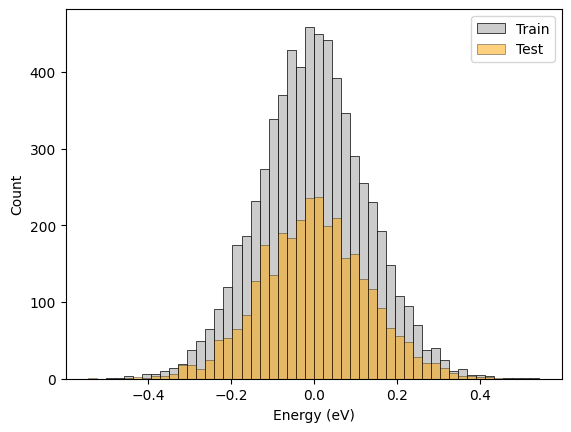

In [12]:

all_energies = np.array([data for data in E_reaction_final])
all_energies_test = np.array([data for data in E_reaction_final_test])
combined_data = np.concatenate((all_energies, all_energies_test))
bin_min = np.min(combined_data)  # min value of both datasets
bin_max = np.max(combined_data)  # max value of both datasets
bins = np.linspace(bin_min, bin_max, 51)  # create 50 bins between min and max

plt.figure()
plt.xlabel("Energy (eV)")
plt.ylabel("Count")
plt.hist(all_energies, bins=bins, facecolor="#CCCCCC", edgecolor="k", lw=0.5, label="Train")
plt.hist(all_energies_test, bins=bins, facecolor="orange", edgecolor="k", lw=0.5, alpha=.5, label="Test")
plt.legend()
plt.savefig("Vrandom_mace_E_reaction_dist.png", dpi=500)

In [13]:
H_barrier = []
M_barrier = []
H_freq = []
M_freq = []
for i, energy in enumerate(E_s_final):
    if diffuse_atom_final[i] == "H":
        H_barrier.append(energy)
        H_freq.append(freq_final[i])
    else:
        M_barrier.append(energy)
        M_freq.append(freq_final[i])
H_barrier_test = []
M_barrier_test = []
H_freq_test = []
M_freq_test = []
for i, energy in enumerate(E_s_final_test):
    if diffuse_atom_final_test[i] == "H":
        H_barrier_test.append(energy)
        H_freq_test.append(freq_final_test[i])
    else:
        M_barrier_test.append(energy)
        M_freq_test.append(freq_final_test[i])

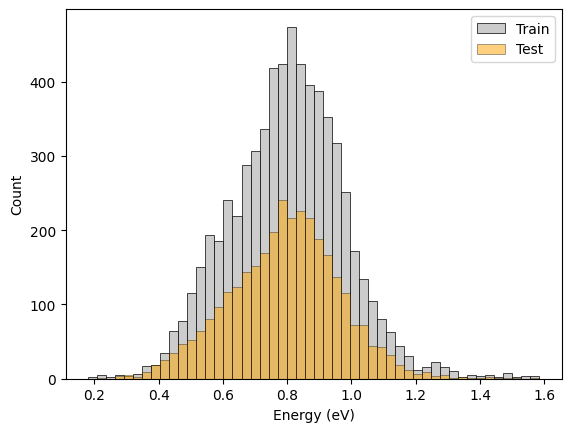

In [14]:

all_energies = np.array([data for data in E_s_final])
all_energies_test = np.array([data for data in E_s_final_test])
combined_data = np.concatenate((all_energies, all_energies_test))
bin_min = np.min(combined_data)  # min value of both datasets
bin_max = np.max(combined_data)  # max value of both datasets
bins = np.linspace(bin_min, bin_max, 51)  # create 50 bins between min and max

plt.figure()
plt.xlabel("Energy (eV)")
plt.ylabel("Count")
plt.hist(all_energies, bins=bins, facecolor="#CCCCCC", edgecolor="k", lw=0.5, label="Train")
plt.hist(all_energies_test, bins=bins, facecolor="orange", edgecolor="k", lw=0.5, alpha=.5, label="Test")
plt.legend()
# plt.show()
plt.savefig("Vrandom_mace_barrier_dist.png", dpi=500)

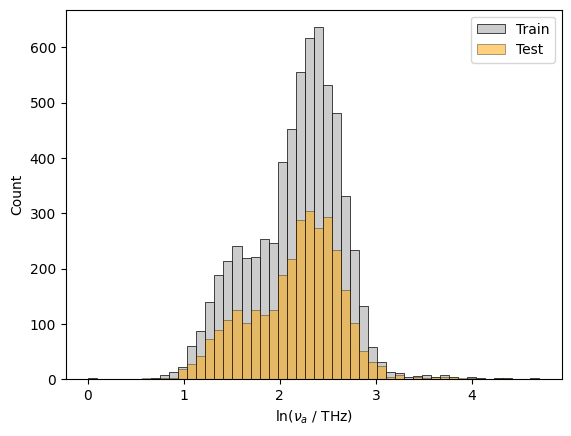

In [15]:

all_energies = np.array([data for data in freq_final])
# all_energies = np.array([data for data in E_s_final])
all_energies_test = np.array([data for data in freq_final_test])
combined_data = np.concatenate((all_energies, all_energies_test))
bin_min = np.min(combined_data)  # min value of both datasets
bin_max = np.max(combined_data)  # max value of both datasets
bins = np.linspace(bin_min, bin_max, 51)  # create 50 bins between min and max

plt.figure()
plt.xlabel("ln($\\nu_{a}$ / THz)")
plt.ylabel("Count")
plt.hist(all_energies, bins=bins, facecolor="#CCCCCC", edgecolor="k", lw=0.5, label="Train")
plt.hist(all_energies_test, bins=bins, facecolor="orange", edgecolor="k", lw=0.5, alpha=.5, label="Test")
plt.legend()
plt.savefig("Vrandom_mace_freq_dist.png", dpi=500)

In [16]:
len(traj_reaction_final), len(traj_reaction_final_test)

(6451, 3175)

In [17]:
io.write("test_react.vasp", traj_reaction_final[2])
io.write("test_prod.vasp", traj_product_final[2])

In [18]:
count = 0
for i, atoms in enumerate(traj_reaction_final):
    if len(atoms)- len(traj_product_final[i]) != 0:
        count +=1
print(count)

0


In [19]:
len(traj_reaction_final)

6451

In [20]:
dataset = make_dataset(traj_reaction_final, traj_product_final, E_r_final, E_p_final, E_s_final, freq_final)
dataset_test = make_dataset(traj_reaction_final_test, traj_product_final_test, E_r_final_test, E_p_final_test, E_s_final_test, freq_final_test)

100%|██████████| 3175/3175 [09:49<00:00,  5.39it/s]


In [23]:
import dill

torch.save(dataset, "Vrandom_mace_dataset.pth.tar", pickle_module=dill)
torch.save(dataset_test, "Vrandom_mace_dataset_test.pth.tar", pickle_module=dill)

In [24]:
dataset = torch.load("Vrandom_mace_dataset.pth.tar")
dataset_test = torch.load("Vrandom_mace_dataset_test.pth.tar")
print(len(dataset), len(dataset_test))

6451 3175


In [25]:
means, stddevs = get_scaler(["barrier", "freq", "delta_e"], dataset)
print(means, stddevs)

{'barrier': tensor(0.8004), 'freq': tensor(2.1658), 'delta_e': tensor(-0.0032)} {'barrier': tensor(0.1766), 'freq': tensor(0.4785), 'delta_e': tensor(0.1292)}


In [26]:
species = ["Cr", "Co", "Ni"]
model = PaiNN(species=species, means=means, stddevs=stddevs)
# reaction_model = ReactionDQN(model)


In [27]:
loss_fn = WeightedSumLoss(keys=("delta_e", "barrier", "freq"),weights=(1.0, 1.0, 1.0), loss_fns=("mse_loss", "mse_loss", "mse_loss"))
# for name, parameters in reaction_model.named_parameters():
#     if "reaction_model" not in name:
#         parameters.requires_grad = False
trainable_params = filter(lambda p: p.requires_grad, model.parameters())

# Set optimizer
optimizer = get_optimizer(
    optim="Adam",
    trainable_params=trainable_params,
    lr=0.0003,
    weight_decay=0.0,
)
scheduler = get_scheduler(
    sched="reduce_on_plateau", optimizer=optimizer
)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset_test, batch_size=8)

Adam Optimizer
Reduce on plateau scheduler


In [28]:
trainer = Trainer(
    model_path="./",
    model=model,
    loss_fn=loss_fn,
    # metric_fn=metric_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    validation_loader=val_loader,
    # normalizer=normalizer,
)

In [29]:
_ = trainer.train(
    device="cuda",
    start_epoch=0,
    n_epochs=50,
    # best_loss=best_loss,
    # best_metric=best_metric,
    # early_stop=early_stop,
    best_model_name= "best_model_mace_Vrandom.pth.tar"
)

Epoch: [0]	
*Validatoin: 	Time 0.046 (0.054)	Loss 0.1156 (0.2750)	
Epoch: [1]	
*Validatoin: 	Time 0.047 (0.054)	Loss 0.1249 (0.2471)	
Epoch: [2]	
*Validatoin: 	Time 0.046 (0.054)	Loss 0.0396 (0.1190)	
Epoch: [3]	
*Validatoin: 	Time 0.046 (0.054)	Loss 0.0691 (0.1118)	
Epoch: [4]	
*Validatoin: 	Time 0.046 (0.054)	Loss 0.0386 (0.0921)	
Epoch: [5]	
*Validatoin: 	Time 0.046 (0.054)	Loss 0.0409 (0.0857)	
Epoch: [6]	
*Validatoin: 	Time 0.045 (0.054)	Loss 0.0369 (0.0785)	
Epoch: [7]	
*Validatoin: 	Time 0.046 (0.054)	Loss 0.0372 (0.0751)	
Epoch: [8]	
*Validatoin: 	Time 0.046 (0.054)	Loss 0.0424 (0.0779)	
Epoch: [9]	
*Validatoin: 	Time 0.046 (0.054)	Loss 0.0459 (0.0717)	
Epoch: [10]	
*Validatoin: 	Time 0.046 (0.053)	Loss 0.0260 (0.0719)	
Epoch: [11]	
*Validatoin: 	Time 0.046 (0.054)	Loss 0.0292 (0.0668)	
Epoch: [12]	
*Validatoin: 	Time 0.046 (0.053)	Loss 0.0412 (0.0653)	
Epoch: [13]	
*Validatoin: 	Time 0.047 (0.054)	Loss 0.0318 (0.0640)	
Epoch: [14]	
*Validatoin: 	Time 0.047 (0.054)	Loss 0.0312 

In [30]:
reaction_model_trained = PaiNN.load("best_model_mace_Vrandom.pth.tar").cuda()

In [31]:
targ_barrier = []
pred_barrier = []

# for data in testset:
#     data.to("cpu")
#     model_learned.eval()
#     model_learned.to('cpu')
#     targ_barrier.append(data.barrier.item())
#     # print(model_learned(data))
#     pred = model_learned(data)['barrier']
#     # print(pred)
#     pred_barrier.append(pred.detach().item())
for data in dataset_test:
    data = batch_to(data, "cuda")
    reaction_model_trained.to("cuda")
    reaction_model_trained.eval()
    # reaction_model.to('cpu')
    targ_barrier.append(data["barrier"].item())
    pred_barrier.append(reaction_model_trained(data)['barrier'].detach().item())

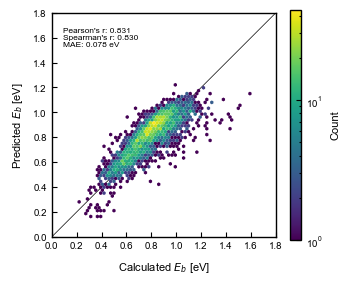

In [32]:
from rgnn.plot import plot_hexbin
fig, ax, r, mae, hb = plot_hexbin(targs=targ_barrier, preds=pred_barrier, prop_key="barrier")
fig.savefig("Vrandom_mace_barrier_results.png", dpi=500)

In [33]:
targ_freq = []
pred_freq = []

for data in dataset_test:
    data = batch_to(data, "cuda")
    # print(data)
    reaction_model_trained.eval()
    reaction_model_trained.device ="cuda"
    reaction_model_trained.to('cuda')
    targ_freq.append(data["freq"].detach().item())
    pred_freq.append(reaction_model_trained(data)['freq'].detach().item())

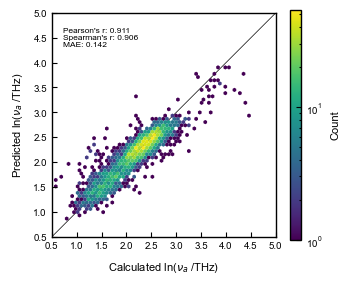

In [34]:
fig, ax, r, mae, hb = plot_hexbin(targs=targ_freq, preds=pred_freq, prop_key="freq")
fig.savefig("Vrandom_mace_freq_results.png", dpi=500)